# Library Management

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [32]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping



# Data Handling and Pre preprocessing

In [33]:
# Step 1: Load the Excel file
file_path = 'Data\Data.csv'  # Update this path if needed
df = pd.read_csv(file_path)

In [34]:
df.head()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   elevatorunitId        1048575 non-null  int64  
 1   elevatorunitnumber    1048575 non-null  object 
 2   CpibUuid              1048575 non-null  object 
 3   countryname           1048575 non-null  object 
 4   DESCRIPTION           1048575 non-null  object 
 5   ItemFieldId           1048575 non-null  object 
 6   PerformanceStartDate  1048575 non-null  object 
 7   PerformanceEndDate    1048575 non-null  object 
 8   Readvalue             1048575 non-null  int64  
 9   Unnamed: 9            0 non-null        float64
 10  Unnamed: 10           0 non-null        float64
 11  Unnamed: 11           0 non-null        float64
 12  Unnamed: 12           0 non-null        float64
dtypes: float64(4), int64(2), object(7)
memory usage: 104.0+ MB
None


In [35]:
# Step 2: Preprocessing
df['Date'] = pd.to_datetime(df['PerformanceStartDate'])
#df['Date'] = df['PerformanceStartDate']

In [36]:
# Step 3: Pivot data to get daily metrics as columns
pivot_df = df.pivot_table(
    index=['elevatorunitId', 'elevatorunitnumber', 'Date'],
    columns='ItemFieldId',
    values='Readvalue',
    aggfunc='sum'
).reset_index()

In [37]:
# Example: Add lag features or calculate differences to capture anomalies
pivot_df['door_reversals_diff'] = pivot_df['door_reversals'].diff()
pivot_df['door_cycles_diff'] = pivot_df['total_door_cycles'].diff()

In [38]:
# Step 4: Fill missing values with 0
pivot_df.fillna(0, inplace=True)
# Sort by time
pivot_df = pivot_df.sort_values(by='Date')

In [39]:
pivot_df.head()
#print(pivot_df.info())

ItemFieldId,elevatorunitId,elevatorunitnumber,Date,door_operations,door_reversals,front_door_cycles,front_door_reversals,rear_door_cycles,rear_door_reversals,slow_door_operations,total_door_cycles,door_reversals_diff,door_cycles_diff
33923,84017,C34593,2025-04-30 00:00:01,0.0,7.0,302.0,4.0,64.0,3.0,0.0,366.0,-4.0,-208.0
12996,20318,W8514,2025-04-30 00:00:01,0.0,1.0,4.0,1.0,4.0,0.0,0.0,8.0,-5.0,-225.0
37045,88036,W7327,2025-04-30 00:00:01,0.0,1.0,192.0,1.0,0.0,0.0,0.0,192.0,-35.0,-71.0
13198,20718,Q32598,2025-04-30 00:00:01,0.0,9.0,279.0,9.0,0.0,0.0,0.0,279.0,9.0,279.0
31519,78299,W1569,2025-04-30 00:00:01,0.0,0.0,33.0,0.0,0.0,0.0,0.0,33.0,0.0,33.0


## Conditional labelling 

In [40]:
# Step 5: Define fault condition (label engineering)
pivot_df['Fault'] = (
    ((pivot_df['door_reversals'] > 100) |
     (pivot_df['front_door_reversals'] > 100) |
     (pivot_df['rear_door_reversals'] > 100)) |

    ((pivot_df['total_door_cycles'] > 0) & (pivot_df['total_door_cycles'] < 10)) |

    (pivot_df['door_reversals_diff'].abs() > 10) |
    (pivot_df['door_cycles_diff'].abs() > 10) |

    (pivot_df['slow_door_operations'] > 10)
).astype(int)

# Then calculate the predicted fault rate:
print("Predicted Fault Rate (%):", pivot_df['Fault'].mean() * 100)


Predicted Fault Rate (%): 33.83439781021898


In [41]:
fault_counts = pivot_df['Fault'].value_counts()
print(fault_counts)

fault_percent = pivot_df['Fault'].value_counts(normalize=True) * 100
print(fault_percent)

Fault
0    29007
1    14833
Name: count, dtype: int64
Fault
0    66.165602
1    33.834398
Name: proportion, dtype: float64


In [42]:
pivot_df.head()
print(pivot_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 43840 entries, 33923 to 42037
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   elevatorunitId        43840 non-null  int64         
 1   elevatorunitnumber    43840 non-null  object        
 2   Date                  43840 non-null  datetime64[ns]
 3   door_operations       43840 non-null  float64       
 4   door_reversals        43840 non-null  float64       
 5   front_door_cycles     43840 non-null  float64       
 6   front_door_reversals  43840 non-null  float64       
 7   rear_door_cycles      43840 non-null  float64       
 8   rear_door_reversals   43840 non-null  float64       
 9   slow_door_operations  43840 non-null  float64       
 10  total_door_cycles     43840 non-null  float64       
 11  door_reversals_diff   43840 non-null  float64       
 12  door_cycles_diff      43840 non-null  float64       
 13  Fault            

## save the Pivot Data set

In [43]:
# Save pivot_df to an Excel file
output_path = 'Data/pivot_output1.xlsx'  # Change path as needed
pivot_df.to_excel(output_path, index=True)

print("pivot_df saved successfully to Excel.")


pivot_df saved successfully to Excel.


In [45]:
# Step 6: Select features and target
features = [
    'front_door_cycles', 'rear_door_cycles',
    'front_door_reversals', 'rear_door_reversals',
    'door_operations', 'total_door_cycles',
    'door_reversals_diff','door_cycles_diff',
    'slow_door_operations'
]
X = pivot_df[features]
y = pivot_df['Fault']

# EDA: Visual Patterns & Correlation

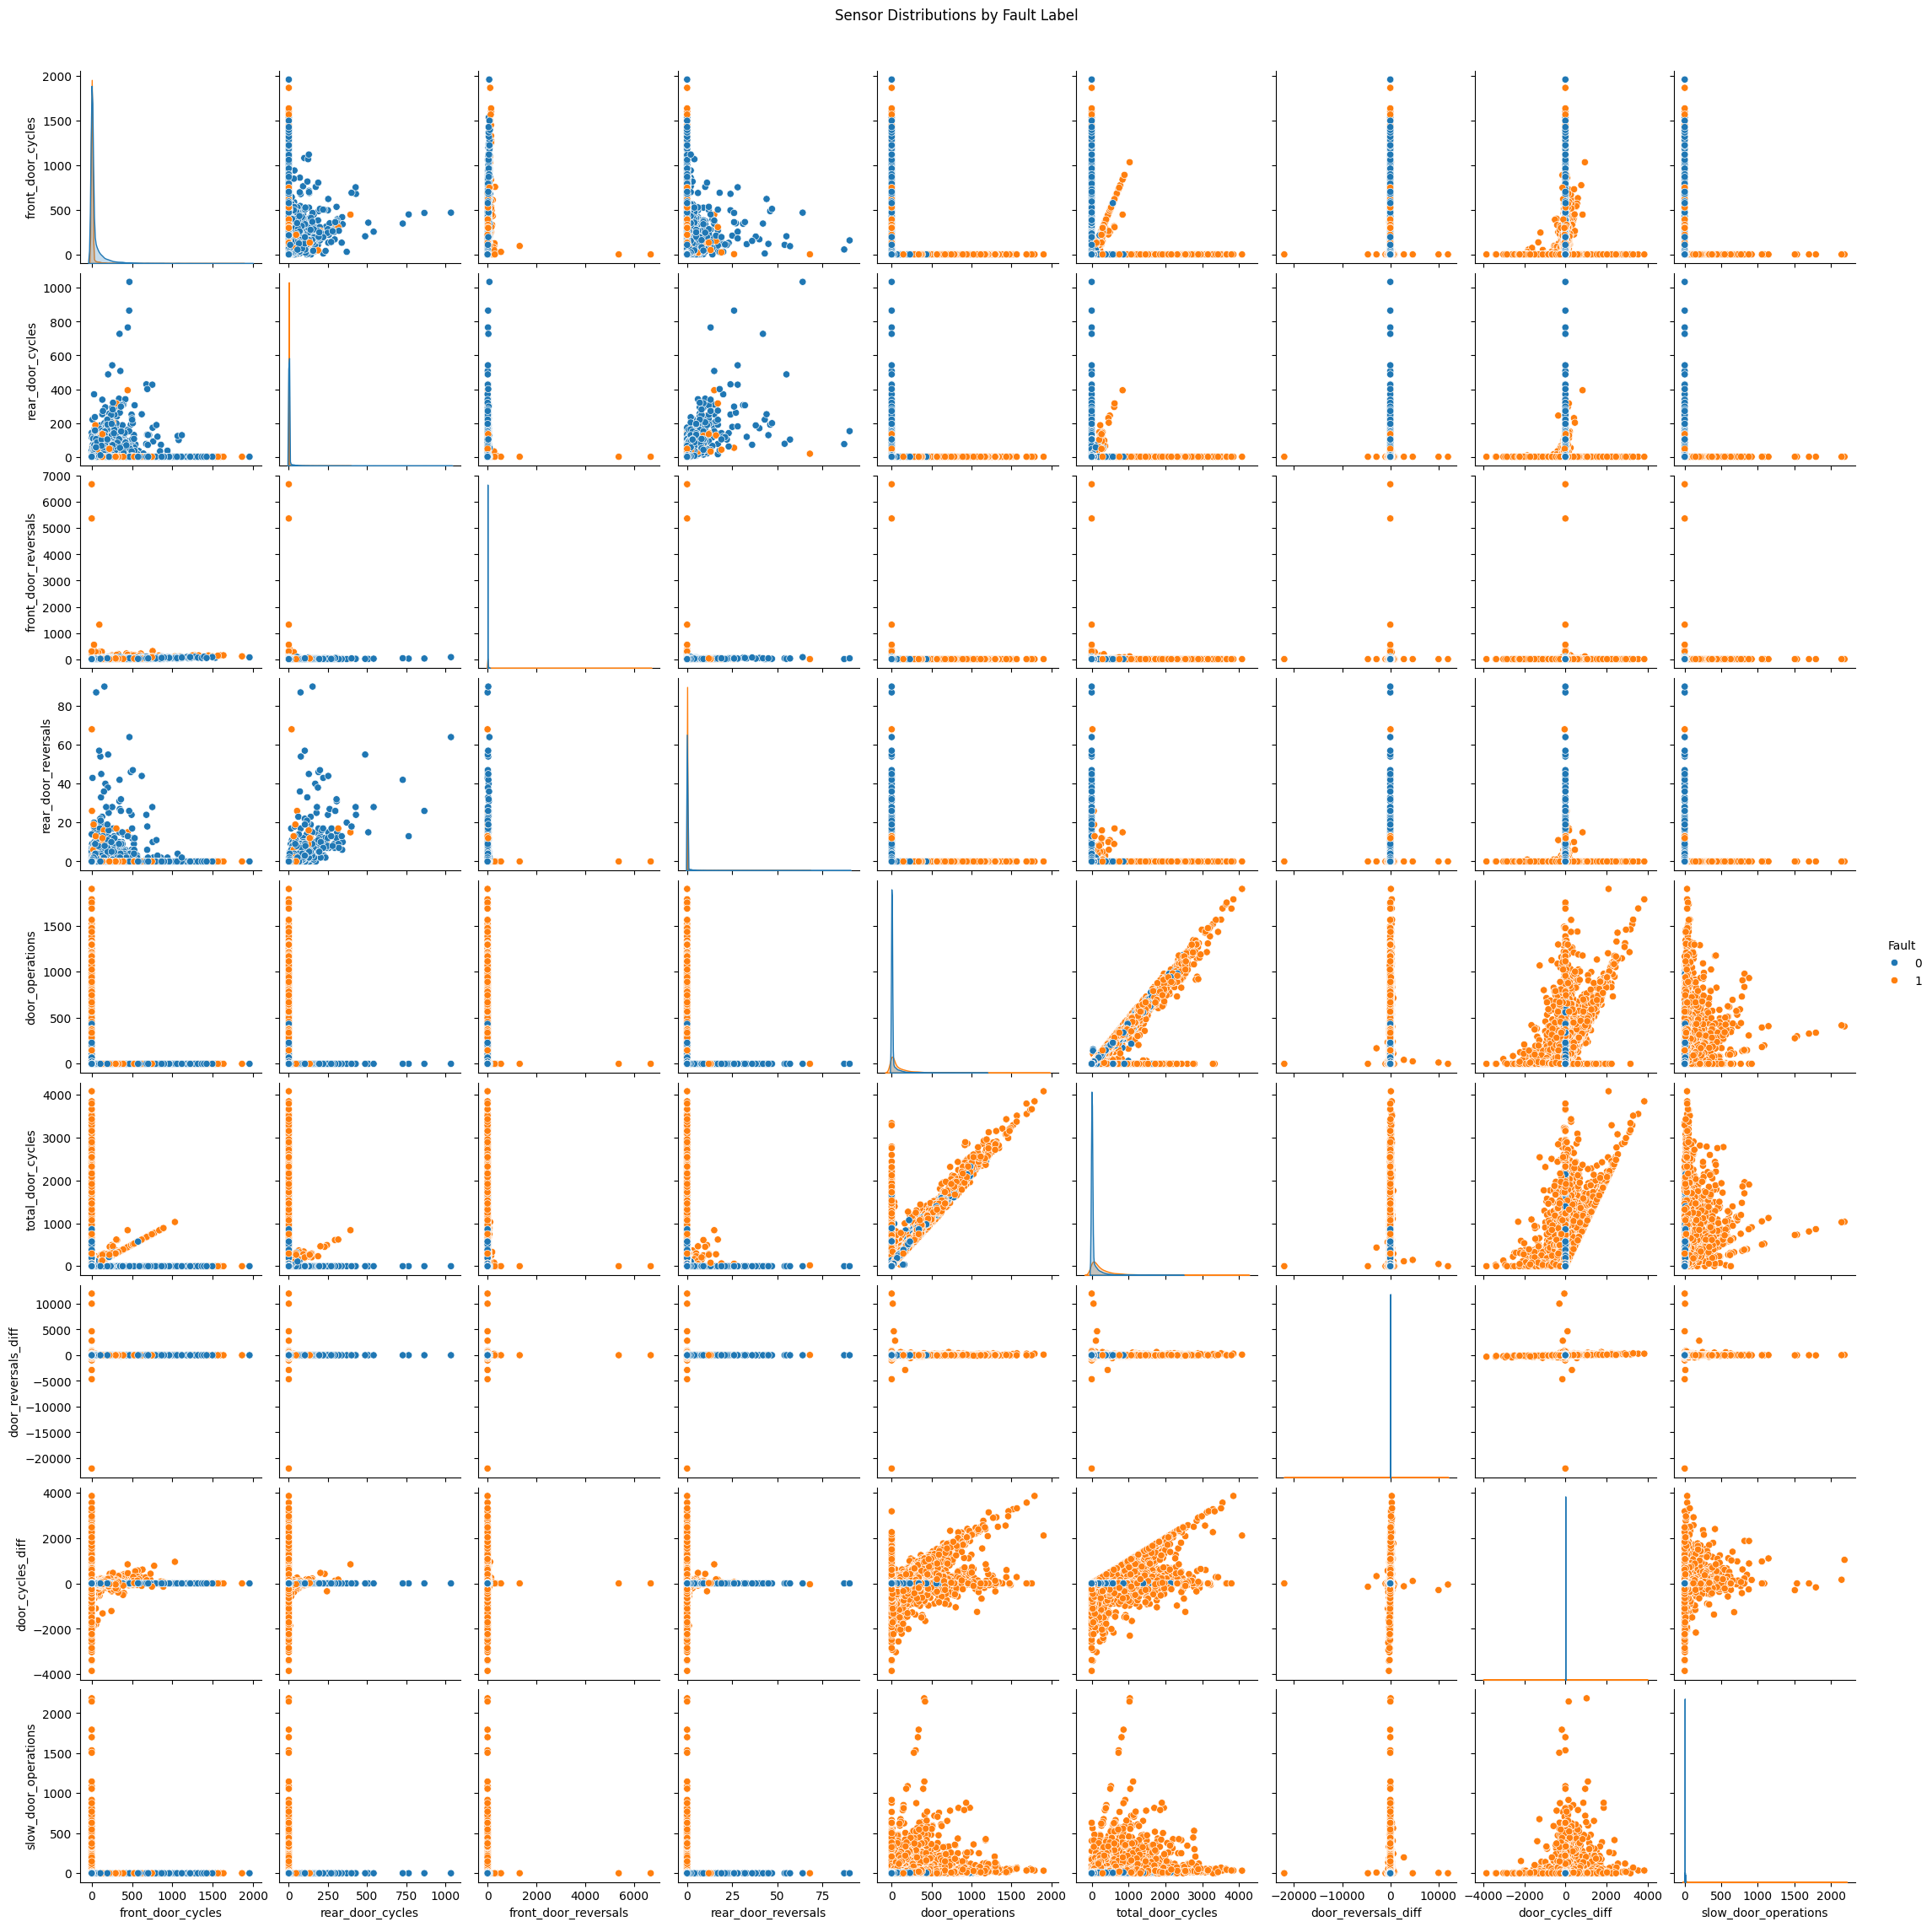

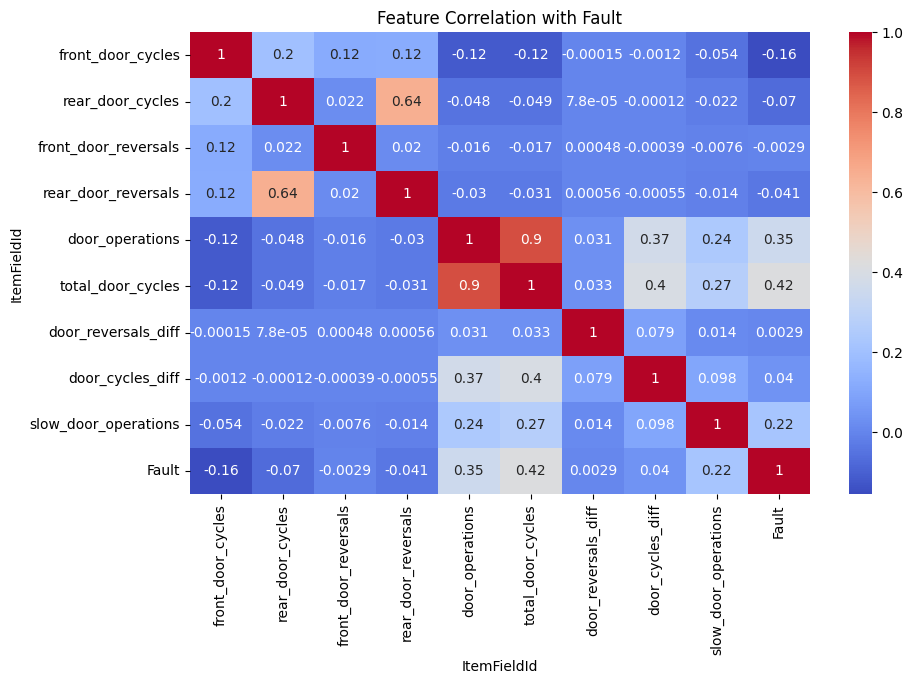

In [46]:
# Pairplot colored by fault
sns.pairplot(pivot_df[features + ['Fault']], hue='Fault')
plt.suptitle("Sensor Distributions by Fault Label", y=1.02)
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df[features + ['Fault']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Fault")
plt.show()


# Model Develoment

In [47]:
# Step 7: Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
# Step 8: Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
# Step 9: Predictions and Evaluation
y_pred = model.predict(X_test)

In [51]:
# Print evaluation results
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[5817    1]
 [   5 2945]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5818
           1       1.00      1.00      1.00      2950

    accuracy                           1.00      8768
   macro avg       1.00      1.00      1.00      8768
weighted avg       1.00      1.00      1.00      8768



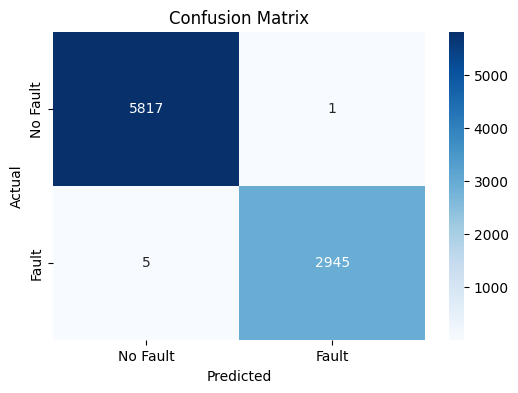

In [68]:
# Optional: Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fault', 'Fault'], yticklabels=['No Fault', 'Fault'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# SHAP Analysis (Model Explainability)

100%|===================| 87323/87680 [03:29<00:00]        

<Figure size 640x480 with 0 Axes>

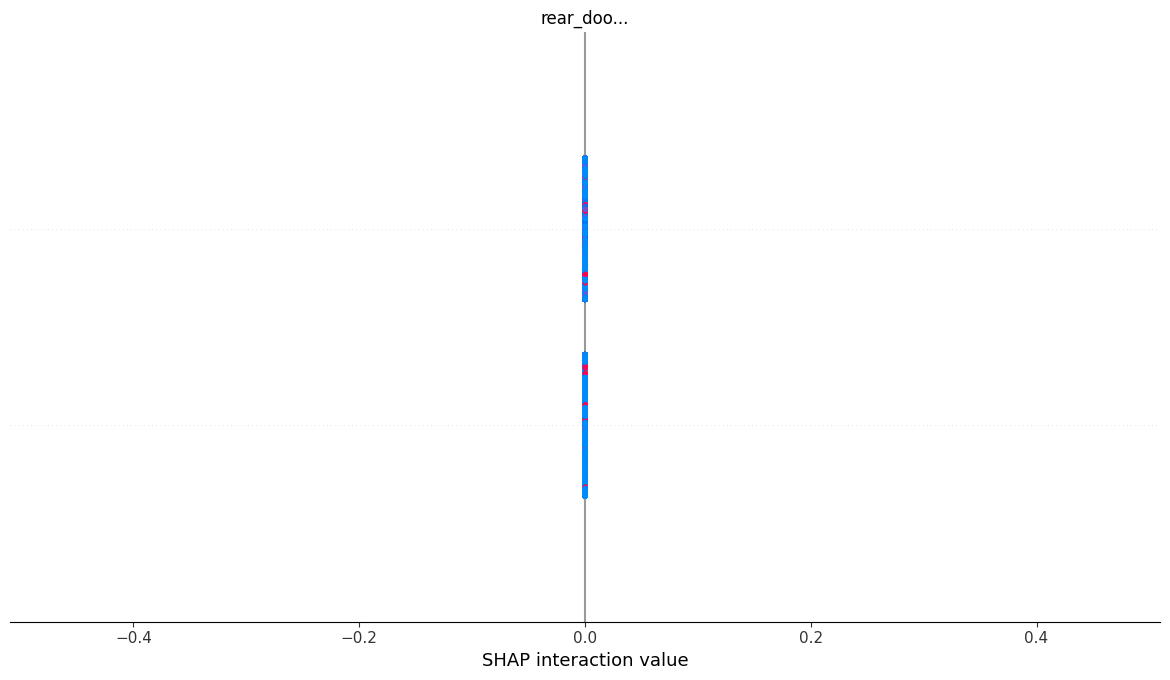

ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (9, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

In [ ]:
# Initialize SHAP Tree Explainer
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# Global importance
shap.summary_plot(shap_values, X, feature_names=features)




In [62]:
shap_values.shape
print(type(shap_values))
print(len(shap_values))
print(shap_values[0].shape)


<class 'shap._explanation.Explanation'>
43840
(9, 2)


In [64]:
# Local explanation for a single sample
shap.plots.waterfall(shap_values[0])


ValueError: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (9, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.

# LSTM Implementation Below

In [22]:
target = 'Fault'
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(pivot_df[features])

In [23]:
# Step 5: Create sequences for LSTM (e.g., 5-day sequences)
sequence_length = 5
X_seq, y_seq = [], []

for i in range(len(scaled_features) - sequence_length):
    X_seq.append(scaled_features[i:i+sequence_length])
    y_seq.append(pivot_df[target].iloc[i + sequence_length])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [24]:
# Step 6: Split into train/test
split_idx = int(0.8 * len(X_seq))
X_train_lstm, X_test_lstm = X_seq[:split_idx], X_seq[split_idx:]
y_train_lstm, y_test_lstm = y_seq[:split_idx], y_seq[split_idx:]

In [25]:
# Step 7: Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(sequence_length, len(features)), return_sequences=False))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\hemam\miniconda3\envs\mlops\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Step 8: Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=8, validation_split=0.2, callbacks=[early_stop])


Epoch 1/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.6468 - loss: 0.5982 - val_accuracy: 0.7459 - val_loss: 0.4192
Epoch 2/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6553 - loss: 0.5561 - val_accuracy: 0.7482 - val_loss: 0.5018
Epoch 3/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6524 - loss: 0.5506 - val_accuracy: 0.7650 - val_loss: 0.4292
Epoch 4/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6615 - loss: 0.5432 - val_accuracy: 0.7464 - val_loss: 0.4237
Epoch 5/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6613 - loss: 0.5461 - val_accuracy: 0.7620 - val_loss: 0.4008
Epoch 6/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6584 - loss: 0.5407 - val_accuracy: 0.7655 - val_loss: 0.4140
Epoch 7/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6620 - loss: 0.5437 - val_accuracy: 0.7678 - val_loss: 0.4017
Epoch 8/50
3507/3507 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6614 - loss: 0

In [29]:
# Step 9: Evaluate
loss, acc = model_lstm.evaluate(X_test_lstm, y_test_lstm)
print(f"\nTest Accuracy: {acc:.2f}")

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5938 - loss: 0.6524

Test Accuracy: 0.65


274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77      5927
           1       0.39      0.14      0.21      2840

    accuracy                           0.65      8767
   macro avg       0.54      0.52      0.49      8767
weighted avg       0.59      0.65      0.59      8767



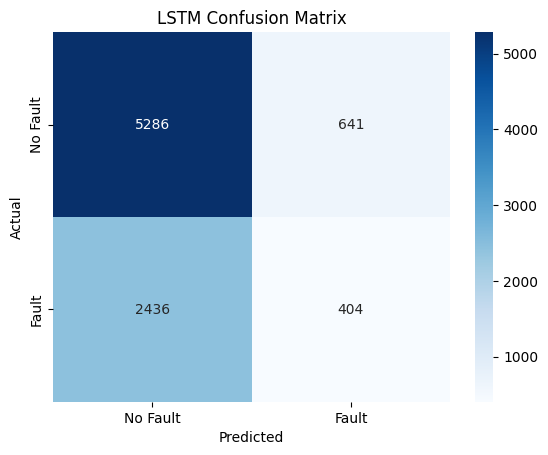

In [30]:
# Step 10: Predictions & Confusion Matrix
y_pred_lstm = (model_lstm.predict(X_test_lstm) > 0.5).astype(int)
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))

conf_matrix_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Fault', 'Fault'], yticklabels=['No Fault', 'Fault'])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()